In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# References

- [SKTBrain/KoBERT](https://github.com/SKTBrain/KoBERT)
- [eagle705/pytorch-bert-crf-ner](https://github.com/eagle705/pytorch-bert-crf-ner/blob/master/Visualization_BERT_NER.ipynb)
- [BERT to the rescue!](https://towardsdatascience.com/bert-to-the-rescue-17671379687f)
- [eagle705/pytorch-bert-crf-ner](https://github.com/eagle705/pytorch-bert-crf-ner/blob/master/data_utils/vocab_tokenizer.py)
- [pytorch-pretrained-bert](https://pypi.org/project/pytorch-pretrained-bert/#usage)

# Load pre-trained model

In [2]:
import io
import time

import pandas as pd
import numpy as np

import tqdm
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams['font.family'] = 'NanumGothic'

import torch
import torch.nn as nn
from kobert.pytorch_kobert import get_pytorch_kobert_model
from gluonnlp.data import SentencepieceTokenizer
from kobert.utils import get_tokenizer
from keras.preprocessing.sequence import pad_sequences
import sentencepiece as spm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, vocab = get_pytorch_kobert_model()
model.to(device)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

using cached model
using cached model


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(8002, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Line

In [3]:
# Load pre-trained model tokenizer
tok_path = get_tokenizer()
print(tok_path)
sp = spm.SentencePieceProcessor()
print(sp)
sp.Load(tok_path)

using cached model
/root/kobert/tokenizer_78b3253a26.model
<sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7f684992fcf0> >


True

In [4]:
# Tokenized input
text = ["누가 기침소리를 내었는가 ? 누구인가 ?"]
train_tokens = list(map(lambda t: ['[CLS]'] + sp.EncodeAsPieces(t) + ['[SEP]'], text))

print(text[0])
print(train_tokens[0])

train_tokens_ids = pad_sequences(list(map(vocab.to_indices, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
print(train_tokens_ids[0][:20])

누가 기침소리를 내었는가 ? 누구인가 ?
['[CLS]', '▁누가', '▁기', '침', '소리', '를', '▁내', '었', '는', '가', '▁?', '▁누구', '인', '가', '▁?', '[SEP]']
[   2 1527 1258 7491 6609 6116 1434 6885 5760 5330  633 1528 7119 5330
  633    3    0    0    0    0]


# Load Data

In [5]:
num_of_cores = 8

In [6]:
# Load and preprocess
price = pd.read_csv('data/example/price_005930.csv', index_col=0)
print(price.shape)

'''
# convert timestamp of price dataframe as datetime object
pool = multiprocessing.pool.ThreadPool(num_of_cores)
args = list(range(price.shape[0]))
def price_to_datetime(i) : 
    price['time'].iloc[i] = pd.to_datetime(str(price['date'].iloc[i])+str(price['time'].iloc[i]), format='%Y%m%d%H%M')
    pbar.update(1)
    return
with tqdm.tqdm(total=len(args)) as pbar:
    for i in range(len(args)):
        pool.apply_async(price_to_datetime, [args[i]])
    pool.close()
    pool.join()       
'''
# convert timestamp of price dataframe as datetime object
with tqdm.tqdm(total=price.shape[0]) as pbar :
    for i in range(price.shape[0]) : 
        price['time'].iloc[i] = pd.to_datetime(str(price['date'].iloc[i])+str(price['time'].iloc[i]), format='%Y%m%d%H%M')
        pbar.update(1)   
# sort in ascending order
price = price.sort_values(by='time').reset_index(drop=True)
price.index = price['time']
price = price.drop(['date', 'time'], axis=1)
display(price)

  0%|          | 0/3429 [00:00<?, ?it/s]

(3429, 7)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 3429/3429 [00:03<00:00, 887.67it/s] 


,close,high,low,open,vol
time,,,,,
2019-10-31 09:01:00,50900,51100,50900,51000,580976
2019-10-31 09:02:00,51100,51100,50900,50900,46699
2019-10-31 09:03:00,51100,51100,51000,51100,13198
2019-10-31 09:04:00,51000,51100,51000,51100,37929
2019-10-31 09:05:00,51000,51100,50900,51000,83816
...,...,...,...,...,...
2019-11-12 15:17:00,52400,52500,52400,52500,12420
2019-11-12 15:18:00,52500,52500,52400,52400,20269
2019-11-12 15:19:00,52500,52500,52400,52500,18480


In [7]:
# Load and preprocess
reply = pd.read_csv('data/example/reply_005930.csv', index_col=0).reset_index(drop=True)
print(reply.shape)

# wrong data in the dataframe
#display(pd.DataFrame(reply.iloc[209]).T)
#display(pd.DataFrame(reply.iloc[210]).T)

'''
# convert timestamp of reply dataframe as datetime object, drop wrong rows
list_to_drop = []
pool = multiprocessing.pool.ThreadPool(num_of_cores)
args = list(range(reply.shape[0]))
def reply_to_datetime(i) : 
    try : 
        reply['Date'].iloc[i] = pd.to_datetime(reply['Date'].iloc[i], format='%Y.%m.%d %H:%M')
        pbar.update(1)
    except Exception as e :
        list_to_drop.append(i)
        pbar.update(1)
    return
with tqdm.tqdm(total=len(args)) as pbar:
    for i in range(len(args)):
        pool.apply_async(reply_to_datetime, [args[i]])
    pool.close()
    pool.join() 
'''
# convert timestamp of reply dataframe as datetime object, drop wrong rows
list_to_drop = []
with tqdm.tqdm(total=reply.shape[0]) as pbar : 
    for i in range(reply.shape[0]) : 
        try : 
            reply['Date'].iloc[i] = pd.to_datetime(reply['Date'].iloc[i], format='%Y.%m.%d %H:%M')
            pbar.update(1)
        except Exception as e :
            list_to_drop.append(i)
            pbar.update(1)
reply = reply.drop(list_to_drop, axis=0)
      
# sort in ascending order
reply = reply.sort_values(by='Date').reset_index(drop=True)
reply.index = reply['Date']
reply = reply.drop(['Date'], axis=1)

display(reply[0:3])

  0%|          | 75/20129 [00:00<00:27, 742.31it/s]

(20129, 7)


100%|██████████| 20129/20129 [00:27<00:00, 724.74it/s]


,Views,Title,Content,Like,Unlike,Ip
Date,,,,,,
2019-10-08 11:22:00,93,홍어도,홍어 먹으로 가야는되 어느지역으로 가야 하냐알려다오 홍어도 사람들아,1.0,0.0,223.38.***.169
2019-10-08 11:23:00,67,[삭제된 게시물의 답글]박원숭 렉서스 잘굴러가냐??,아들은 찾았고?? 딸는 아직도 돈많이든다는 스위스 유학중이고??? 미누라 일감은 ...,4.0,0.0,125.139.***.71
2019-10-08 11:27:00,108,자격없는 문재인 때문에,나라가 요지경 \r\r\nㅂㅅ 문재인,8.0,4.0,58.238.***.52


# Merge Dataset

In [8]:
day_start = max(price.index[0], reply.index[0])
day_end = min(price.index[-1], reply.index[-1])
print(day_start)
print(day_end)

2019-10-31 09:01:00
2019-11-12 15:30:00


,Views,Title,Content,Like,Unlike,Ip,close,high,low,open,vol
key_0,,,,,,,,,,,
2019-10-31 09:01:00,192.0,계엄령 문건 덮었다는 '윤석열 직인'···알고보니 자동 출력,\r\n이젠 호모쉐퀴들도 부역자 노릇을 하는구나\r\r\n \r\n군대도 안다녀온...,6.0,4.0,125.178.***.115,50900.0,51100.0,50900.0,51000.0,580976.0
2019-10-31 09:01:00,544.0,오늘 실적발표 일...,자료는 공개되었네요\r\r\n못보신 분들은 확인하세요\r\r\n \r\nhttps:...,0.0,0.0,112.216.***.242,50900.0,51100.0,50900.0,51000.0,580976.0
2019-10-31 09:03:00,135.0,지금은 `폴더블폰` 시대…화면 확장 한계 넘는다ㅋ,ㅋㅋ,0.0,0.0,223.62.***.176,51100.0,51100.0,51000.0,51100.0,13198.0
2019-10-31 09:04:00,148.0,"삼성, 새로운 폴더블폰 공개…'갤럭시 폴드는 시작일 뿐'ㅋ",ㅋㅋ,0.0,0.0,223.62.***.176,51000.0,51100.0,51000.0,51100.0,37929.0
2019-10-31 09:05:00,203.0,"삼성, 내년 폴더블폰 판매 10배 이상 늘린다…최대 600만대 달할 듯ㅋ",ㅋㅋ,3.0,0.0,223.62.***.176,51000.0,51100.0,50900.0,51000.0,83816.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-12 15:16:00,NaN,NaN,NaN,NaN,NaN,NaN,52500.0,52500.0,52400.0,52500.0,15225.0
2019-11-12 15:18:00,NaN,NaN,NaN,NaN,NaN,NaN,52500.0,52500.0,52400.0,52400.0,20269.0
2019-11-12 15:19:00,NaN,NaN,NaN,NaN,NaN,NaN,52500.0,52500.0,52400.0,52500.0,18480.0


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


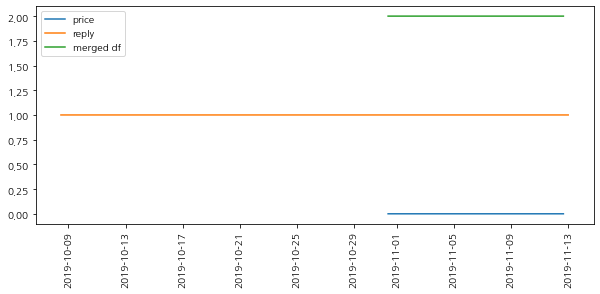

In [9]:
# merge dataframe
reply_common = reply[(reply.index >= day_start) & (reply.index <= day_end)]
price_common = price[(price.index >= day_start) & (price.index <= day_end)]
df = reply_common.merge(price_common, how='outer', left_on=reply_common.index, right_on=price_common.index)
df.index = df['key_0']
df = df.drop(['key_0'], axis=1)
display(df)

# check intersection of timestamp
plt.figure(figsize=(10, 4))
plt.plot(price.index, np.zeros(price.shape[0]), label='price')
plt.plot(reply.index, np.ones(reply.shape[0]), label='reply')
plt.plot(df.index, np.full(df.shape[0], 2), label='merged df')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Preprocess Functions

### 부탁드릴 내용
- 제목 미리보기?
    - '오늘 실적발표 일...'
    - 페이지에 들어가서 잘리지 않은 제목으로

In [10]:
from urlextract import URLExtract
import re

In [11]:
df[0:1]

,Views,Title,Content,Like,Unlike,Ip,close,high,low,open,vol
key_0,,,,,,,,,,,
2019-10-31 09:01:00,192.0,계엄령 문건 덮었다는 '윤석열 직인'···알고보니 자동 출력,\r\n이젠 호모쉐퀴들도 부역자 노릇을 하는구나\r\r\n \r\n군대도 안다녀온...,6.0,4.0,125.178.***.115,50900.0,51100.0,50900.0,51000.0,580976.0


In [12]:
def replace_tag(content) : 
    return content.replace('\r', '').replace('\n', '').replace('\\', '')

In [13]:
def replace_link(content): 
    extractor = URLExtract()
    urls = extractor.find_urls(content)
    for url in urls : 
        content = content.replace(url, '링크')

    return content

In [14]:
def replace_punctuation(content) : 
    return content.replace(',', '')

In [15]:
def get_numbers(content) : 
    content = content.replace('만원', '0000')
    return content, [int(x) for x in re.findall('\d+', content)]

In [16]:
band = 0.1
# price in txt가 close와 얼마나 비슷한지 확인하고, 너무 차이나면 관계없는 숫자이기때문에 걸러야 함
# price in txt의 dimension도 확인하고, 너무 많을 경우 의미없는 숫자들일 가능성이 큼
def get_price_in_txt(numbers_in_txt, close) : 
    if len(numbers_in_txt) == 1 :
        number_in_txt = numbers_in_txt[0]
        if (number_in_txt <= close * (1+band)) and (number_in_txt >= close * (1-band)) :
            return number_in_txt
        else : 
            return -1
    else :
        return -1

In [17]:
def preprocess_pipeline(text, close) : 
    bypass = replace_tag(text)
    bypass = replace_link(bypass)
    bypass = replace_punctuation(bypass)
    bypass, numbers_in_txt = get_numbers(bypass)
    price_in_txt = get_price_in_txt(numbers_in_txt, close)
    
    return bypass, price_in_txt

### Examples

In [18]:
idx = 10
close = df['close'][idx]
text = df['Title'][idx]
bypass, price_in_txt = preprocess_pipeline(text, close)
print(bypass)
print(close, price_in_txt)

# Tokenized input
bypass = [bypass]
train_tokens = list(map(lambda t: ['[CLS]'] + sp.EncodeAsPieces(t) + ['[SEP]'], bypass))
print(train_tokens[0])
train_tokens_ids = pad_sequences(list(map(vocab.to_indices, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
print(train_tokens_ids[0][:20])

53000  갇다=========
51200.0 53000
['[CLS]', '▁5', '3000', '▁', '갇', '다', '=', '=', '=', '=', '=', '=', '=', '=', '=', '[SEP]']
[   2  611  146  517 5339 5782  254  254  254  254  254  254  254  254
  254    3    0    0    0    0]


In [19]:
idx = 31
close = df['close'][idx]
text = df['Content'][idx]
bypass, price_in_txt = preprocess_pipeline(text, close)
print(bypass)
print(close, price_in_txt)

# Tokenized input
bypass = [bypass]
train_tokens = list(map(lambda t: ['[CLS]'] + sp.EncodeAsPieces(t) + ['[SEP]'], bypass))
print(train_tokens[0])
train_tokens_ids = pad_sequences(list(map(vocab.to_indices, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
print(train_tokens_ids[0][:20])

불쌍하다. 추운깜빵에서. 병악화되어 죽을수도있다
51100.0 -1
['[CLS]', '▁불', '쌍', '하다', '.', '▁추', '운', '깜', '빵', '에서', '.', '▁병', '악', '화', '되어', '▁죽', '을', '수', '도', '있다', '[SEP]']
[   2 2485 6759 7798   54 4541 7010 5597 6463 6903   54 2351 6811 7941
 5894 4244 7088 6629 5859 7143]


# Apply Preprocessing Functions

In [20]:
def preprocess_content(idx) : 
    close = df['close'][idx]
    title = df['Title'][idx]
    content = df['Content'][idx]
    
    bypass_title, price_in_title = preprocess_pipeline(title, close)
    bypass_content, price_in_content = preprocess_pipeline(content, close)
    
    df['Title'].iloc[idx] = bypass_title
    df['Content'].iloc[idx] = bypass_content
    
    if df['PriceInTxt'].iloc[idx] == -1 : 
        df['PriceInTxt'].iloc[idx] = price_in_title
    if df['PriceInTxt'].iloc[idx] == -1 : 
        df['PriceInTxt'].iloc[idx] = price_in_content
    pbar.update(1)
    return

df['PriceInTxt'] = -1
preprocess_content(0)
display(df[0:1])

,Views,Title,Content,Like,Unlike,Ip,close,high,low,open,vol,PriceInTxt
key_0,,,,,,,,,,,,
2019-10-31 09:01:00,192.0,계엄령 문건 덮었다는 '윤석열 직인'···알고보니 자동 출력,이젠 호모쉐퀴들도 부역자 노릇을 하는구나 군대도 안다녀온 게이새끼 허위사실유포로 ...,6.0,4.0,125.178.***.115,50900.0,51100.0,50900.0,51000.0,580976.0,-1


In [21]:
# convert timestamp of price dataframe as datetime object
pool = multiprocessing.pool.ThreadPool(num_of_cores)
args = list(range(df.shape[0]))
df['PriceInTxt'] = -1

with tqdm.tqdm(total=len(args)) as pbar:
    for i in range(len(args)):
        pool.apply_async(preprocess_content, [args[i]])
    pool.close()
    pool.join()       
    
df.to_pickle('data/example/preprocessed_005930.pkl')

 74%|███████▍  | 6033/8150 [09:54<03:28, 10.15it/s] 


# Handle Numeric Values

In [22]:
df

,Views,Title,Content,Like,Unlike,Ip,close,high,low,open,vol,PriceInTxt
key_0,,,,,,,,,,,,
2019-10-31 09:01:00,192.0,계엄령 문건 덮었다는 '윤석열 직인'···알고보니 자동 출력,이젠 호모쉐퀴들도 부역자 노릇을 하는구나 군대도 안다녀온 게이새끼 허위사실유포로 ...,6.0,4.0,125.178.***.115,50900.0,51100.0,50900.0,51000.0,580976.0,-1
2019-10-31 09:01:00,544.0,오늘 실적발표 일...,자료는 공개되었네요못보신 분들은 확인하세요 링크 컨콜은 아래에서 신청 후 참여 가능...,0.0,0.0,112.216.***.242,50900.0,51100.0,50900.0,51000.0,580976.0,-1
2019-10-31 09:03:00,135.0,지금은 `폴더블폰` 시대…화면 확장 한계 넘는다ㅋ,ㅋㅋ,0.0,0.0,223.62.***.176,51100.0,51100.0,51000.0,51100.0,13198.0,-1
2019-10-31 09:04:00,148.0,삼성 새로운 폴더블폰 공개…'갤럭시 폴드는 시작일 뿐'ㅋ,ㅋㅋ,0.0,0.0,223.62.***.176,51000.0,51100.0,51000.0,51100.0,37929.0,-1
2019-10-31 09:05:00,203.0,삼성 내년 폴더블폰 판매 10배 이상 늘린다…최대 600만대 달할 듯ㅋ,ㅋㅋ,3.0,0.0,223.62.***.176,51000.0,51100.0,50900.0,51000.0,83816.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-12 15:16:00,NaN,NaN,NaN,NaN,NaN,NaN,52500.0,52500.0,52400.0,52500.0,15225.0,-1
2019-11-12 15:18:00,NaN,NaN,NaN,NaN,NaN,NaN,52500.0,52500.0,52400.0,52400.0,20269.0,-1
2019-11-12 15:19:00,NaN,NaN,NaN,NaN,NaN,NaN,52500.0,52500.0,52400.0,52500.0,18480.0,-1


In [23]:
columns = df.select_dtypes('float64').columns
for column in columns : 
    df[column] = df[column].astype('Int64')

df.to_pickle('data/example/preprocessed_005930.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8150 entries, 2019-10-31 09:01:00 to 2019-11-12 15:30:00
Data columns (total 12 columns):
Views         6033 non-null Int64
Title         6033 non-null object
Content       6033 non-null object
Like          5988 non-null Int64
Unlike        5988 non-null Int64
Ip            5988 non-null object
close         3800 non-null Int64
high          3800 non-null Int64
low           3800 non-null Int64
open          3800 non-null Int64
vol           3800 non-null Int64
PriceInTxt    8150 non-null int64
dtypes: Int64(8), int64(1), object(3)
memory usage: 1.2+ MB


# Prepare Dataset

In [24]:
df = pd.read_pickle('data/example/preprocessed_005930.pkl')
df

,Views,Title,Content,Like,Unlike,Ip,close,high,low,open,vol,PriceInTxt
key_0,,,,,,,,,,,,
2019-10-31 09:01:00,192,계엄령 문건 덮었다는 '윤석열 직인'···알고보니 자동 출력,이젠 호모쉐퀴들도 부역자 노릇을 하는구나 군대도 안다녀온 게이새끼 허위사실유포로 ...,6,4,125.178.***.115,50900,51100,50900,51000,580976,-1
2019-10-31 09:01:00,544,오늘 실적발표 일...,자료는 공개되었네요못보신 분들은 확인하세요 링크 컨콜은 아래에서 신청 후 참여 가능...,0,0,112.216.***.242,50900,51100,50900,51000,580976,-1
2019-10-31 09:03:00,135,지금은 `폴더블폰` 시대…화면 확장 한계 넘는다ㅋ,ㅋㅋ,0,0,223.62.***.176,51100,51100,51000,51100,13198,-1
2019-10-31 09:04:00,148,삼성 새로운 폴더블폰 공개…'갤럭시 폴드는 시작일 뿐'ㅋ,ㅋㅋ,0,0,223.62.***.176,51000,51100,51000,51100,37929,-1
2019-10-31 09:05:00,203,삼성 내년 폴더블폰 판매 10배 이상 늘린다…최대 600만대 달할 듯ㅋ,ㅋㅋ,3,0,223.62.***.176,51000,51100,50900,51000,83816,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-12 15:16:00,NaN,NaN,NaN,NaN,NaN,NaN,52500,52500,52400,52500,15225,-1
2019-11-12 15:18:00,NaN,NaN,NaN,NaN,NaN,NaN,52500,52500,52400,52400,20269,-1
2019-11-12 15:19:00,NaN,NaN,NaN,NaN,NaN,NaN,52500,52500,52400,52500,18480,-1


# Model

In [25]:
class BertRegressor(nn.Module) : 
    def __init__(self) : 
        super(BertRegressor, self).__init__()
        self.bert, self.vocab = get_pytorch_kobert_model()
        self.relu = nn.ReLU()
        self.linear = nn.Linear(768, 1)
    
    def forward(self, tokens) : 
        _, pooled_output = self.bert(tokens, utput_all=False)
        linear_output = self.relu(pooled_output)
        predicted_price = self.linear(linear_output)

        return predicted_price

In [26]:
bert_reg = BertRegressor()
bert_reg.to(device)
optimizer = torch.optim.Adam(bert_reg.parameters(), lr=3e-6)
bert_reg.train()

using cached model
using cached model


BertRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

# Training